In [1]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 17.2 MB/s 
     |████████████████████████████████| 182 kB 51.9 MB/s 
     |████████████████████████████████| 168 kB 48.2 MB/s 
     |████████████████████████████████| 62 kB 493 kB/s 
     |████████████████████████████████| 168 kB 28.0 MB/s 
     |████████████████████████████████| 166 kB 59.1 MB/s 
     |████████████████████████████████| 166 kB 22.6 MB/s 
     |████████████████████████████████| 162 kB 46.7 MB/s 
     |████████████████████████████████| 162 kB 29.4 MB/s 
     |████████████████████████████████| 158 kB 57.3 MB/s 
     |████████████████████████████████| 157 kB 12.8 MB/s 
     |████████████████████████████████| 157 kB 36.2 MB/s 
     |████████████████████████████████| 157 kB 51.0 MB/s 
     |████████████████████████████████| 157 kB 42.0 MB/s 
     |████████████████████████████████| 157 kB 24.8 MB/s 
     |████████████████████████████████| 157 kB 12.4 MB/s 
     |████████████████████████████████| 157 kB 32.0 MB/s 
     |██████████

In [2]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
import tensorflow as tf
import wandb
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

2.2 Fetch and Data Segregation


In [5]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "animals",
  "artifact_name": "animals_raw_data:latest",
}

In [6]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="pablosanttana",project=args["project_name"], job_type="preprocessing")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

wandb: Currently logged in as: pablosanttana. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact animals_raw_data:latest, 116.12MB. 5935 files... 
wandb:   5935 of 5935 files downloaded.  
Done. 0:2:15.2
28-11-2022 02:54:30 Path: ./artifacts/animals_raw_data:v0


In [24]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

raw_wb = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     image_size=IMG_SIZE,
                                                     label_mode='categorical')

Found 5935 files belonging to 3 classes.


In [25]:
# 80% train, 20% validation and test
all_batches = tf.data.experimental.cardinality(raw_wb)
valtest_dataset = raw_wb.take(all_batches // 5)
train_dataset = raw_wb.skip(all_batches // 5)

valtest_batches = tf.data.experimental.cardinality(valtest_dataset)
test_dataset = valtest_dataset.take(valtest_batches // 5)
validation_dataset = valtest_dataset.skip(valtest_batches // 5)

In [26]:
print('Number of raw batches: %d' % tf.data.experimental.cardinality(raw_wb))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of raw batches: 186
Number of train batches: 149
Number of validation batches: 30
Number of test batches: 7


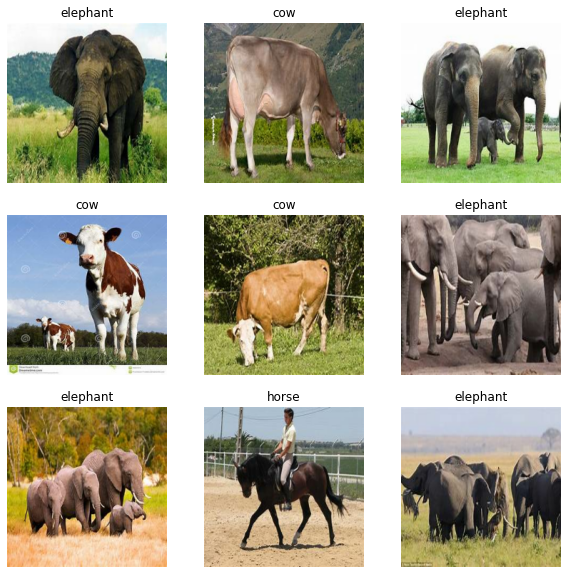

In [27]:
class_names = raw_wb.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")

2.3 Configure the dataset for performance

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Use data augmentation

In [29]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

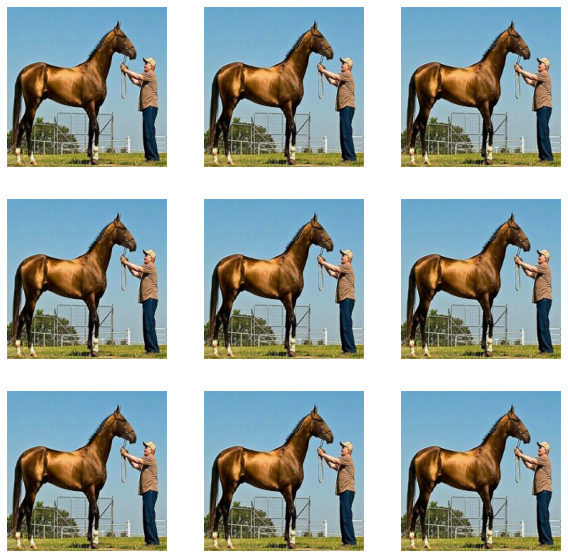

In [30]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

 Create the base model from the pre-trained convnets

In [31]:

# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [32]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [33]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


Feature extraction

In [34]:
model.trainable = False

Add a classification head

In [35]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [36]:
prediction_layer = tf.keras.layers.Dense(3,"softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [37]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

 Compile the model



In [38]:
# initialize the optimizer and model
learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

Train and Evalute the model

In [39]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0   

In [40]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=10,
                    verbose=1)

Epoch 1/10
149/149 [==============================] - 34s 213ms/step - loss: 1.5455 - accuracy: 0.6698 - val_loss: 0.4823 - val_accuracy: 0.8885
Epoch 2/10
149/149 [==============================] - 33s 215ms/step - loss: 0.6309 - accuracy: 0.8179 - val_loss: 0.2794 - val_accuracy: 0.9333
Epoch 3/10
149/149 [==============================] - 33s 213ms/step - loss: 0.4601 - accuracy: 0.8579 - val_loss: 0.2189 - val_accuracy: 0.9458
Epoch 4/10
149/149 [==============================] - 34s 217ms/step - loss: 0.3800 - accuracy: 0.8737 - val_loss: 0.2136 - val_accuracy: 0.9479
Epoch 5/10
149/149 [==============================] - 34s 217ms/step - loss: 0.3566 - accuracy: 0.8874 - val_loss: 0.1950 - val_accuracy: 0.9469
Epoch 6/10
149/149 [==============================] - 34s 219ms/step - loss: 0.3144 - accuracy: 0.8979 - val_loss: 0.1934 - val_accuracy: 0.9510
Epoch 7/10
149/149 [==============================] - 34s 219ms/step - loss: 0.3087 - accuracy: 0.8956 - val_loss: 0.1593 - val_ac

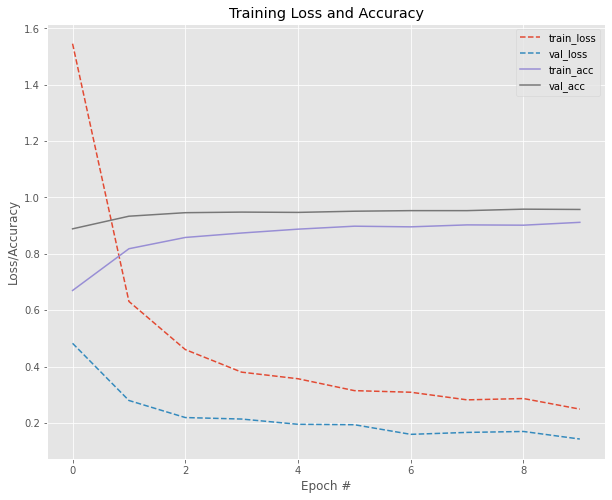

In [42]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 10), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 10), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [43]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "Training Loss and Accuracy of the transfer learning with feature extractor": wandb.Image(fig),
    }
)

28-11-2022 03:09:31 Uploading figures


In [44]:
y = np.concatenate([y for x, y in test_dataset], axis=0)
y2 = np.concatenate([y for x, y in test_dataset], axis=0)

In [45]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [46]:
# evaluate the network
print("[INFO] evaluating network...")
print(class_names)
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
['cow', 'elephant', 'horse']
7/7 [==============================] - 1s 156ms/step
              precision    recall  f1-score   support

         cow       0.92      0.96      0.94        70
    elephant       1.00      1.00      1.00        48
       horse       0.97      0.94      0.96       106

    accuracy                           0.96       224
   macro avg       0.96      0.97      0.96       224
weighted avg       0.96      0.96      0.96       224



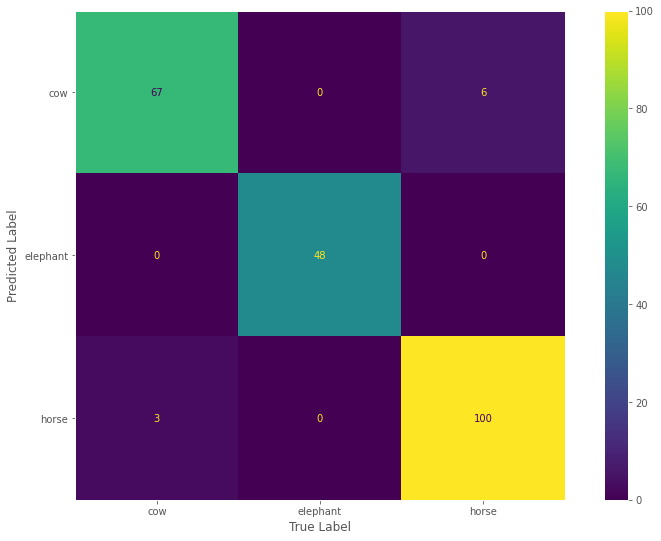

In [47]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(14,9))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [48]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix of the transfer learning with feature extractor": wandb.Image(fig_confusion_matrix),
    }
)

28-11-2022 03:10:13 Uploading figures


Transfer learning with fine-tuning

In [50]:
# import the necessary packages
from tensorflow.keras.applications import VGG16

# whether or not to include top of CNN
include_top = 0

# load the VGG16 network
print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top= include_top > 0)
print("[INFO] showing layers...")

# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] loading network...
[INFO] showing layers...
[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D


In [51]:
# import the necessary packages
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# a fully connect network
class FCHeadNet:
	@staticmethod
	def build(baseModel, classes, neurons):
		# initialize the head model that will be placed on top of
		# the base, then add a FC layer
		headModel = baseModel.output
		headModel = Flatten(name="flatten")(headModel)
		headModel = Dense(neurons, activation="relu")(headModel)
		headModel = Dropout(0.5)(headModel)

		# add a softmax layer
		headModel = Dense(classes, activation="softmax")(headModel)

		# return the model
		return headModel

First Stage

In [52]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD

In [53]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [54]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
outputs = base_model(x, training=False)
base_model = tf.keras.Model(inputs, outputs)

In [55]:
base_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
Total params: 14,714,688
Trainable params: 14,714,688
Non-t

In [56]:
# initialize the new head of the network, a set of FC layers
# followed by a softmax classifier
headModel = FCHeadNet.build(base_model, len(class_names), 256)

In [57]:
# place the head FC model on top of the base model -- this will
# become the actual model we will train
model = Model(inputs=base_model.input, outputs=headModel)

In [58]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [59]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [60]:
# loop over all layers in the base model and freeze them so they
# will *not* be updated during the training process
for layer in model.layers[4].layers:
	layer.trainable = False

In [61]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [62]:
# RMSprop is frequently used in situations where we need to quickly obtain
# reasonable performance (as is the case when we are trying to “warm up” a set of FC layers).
opt = RMSprop(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [63]:
# train the head of the network for a few epochs (all other
# layers are frozen) -- this will allow the new FC layers to
# start to become initialized with actual "learned" values
# versus pure random
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=10,
                    verbose=1)

[INFO] training head...
Epoch 1/10
149/149 [==============================] - 34s 212ms/step - loss: 8.1329 - accuracy: 0.7478 - val_loss: 0.7706 - val_accuracy: 0.8927
Epoch 2/10
149/149 [==============================] - 33s 214ms/step - loss: 0.7424 - accuracy: 0.8365 - val_loss: 0.3420 - val_accuracy: 0.9187
Epoch 3/10
149/149 [==============================] - 34s 219ms/step - loss: 0.6536 - accuracy: 0.8607 - val_loss: 0.3527 - val_accuracy: 0.9344
Epoch 4/10
149/149 [==============================] - 35s 219ms/step - loss: 0.5850 - accuracy: 0.8729 - val_loss: 0.3648 - val_accuracy: 0.9479
Epoch 5/10
149/149 [==============================] - 34s 219ms/step - loss: 0.6127 - accuracy: 0.8855 - val_loss: 0.2721 - val_accuracy: 0.9625
Epoch 6/10
149/149 [==============================] - 34s 221ms/step - loss: 0.5944 - accuracy: 0.8948 - val_loss: 0.2956 - val_accuracy: 0.9500
Epoch 7/10
149/149 [==============================] - 34s 221ms/step - loss: 0.5209 - accuracy: 0.8977 - v

Second Stage

In [64]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [65]:
# loop over the layers in the base model network and display them to the
# console
for (i, layer) in enumerate(model.layers[4].layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D


In [66]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [67]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in model.layers[4].layers[15:]:
	layer.trainable = True

In [68]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [69]:
# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

[INFO] re-compiling model...


In [70]:
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=10,
                    verbose=1)

[INFO] training head...
Epoch 1/10
149/149 [==============================] - 40s 243ms/step - loss: 0.3280 - accuracy: 0.9002 - val_loss: 0.3079 - val_accuracy: 0.9604
Epoch 2/10
149/149 [==============================] - 38s 242ms/step - loss: 0.2686 - accuracy: 0.9228 - val_loss: 0.2390 - val_accuracy: 0.9594
Epoch 3/10
149/149 [==============================] - 38s 247ms/step - loss: 0.2293 - accuracy: 0.9350 - val_loss: 0.1240 - val_accuracy: 0.9729
Epoch 4/10
149/149 [==============================] - 38s 248ms/step - loss: 0.1886 - accuracy: 0.9390 - val_loss: 0.1829 - val_accuracy: 0.9708
Epoch 5/10
149/149 [==============================] - 38s 246ms/step - loss: 0.1625 - accuracy: 0.9470 - val_loss: 0.2561 - val_accuracy: 0.9625
Epoch 6/10
149/149 [==============================] - 38s 245ms/step - loss: 0.1520 - accuracy: 0.9514 - val_loss: 0.2231 - val_accuracy: 0.9656
Epoch 7/10
149/149 [==============================] - 38s 245ms/step - loss: 0.1383 - accuracy: 0.9577 - v

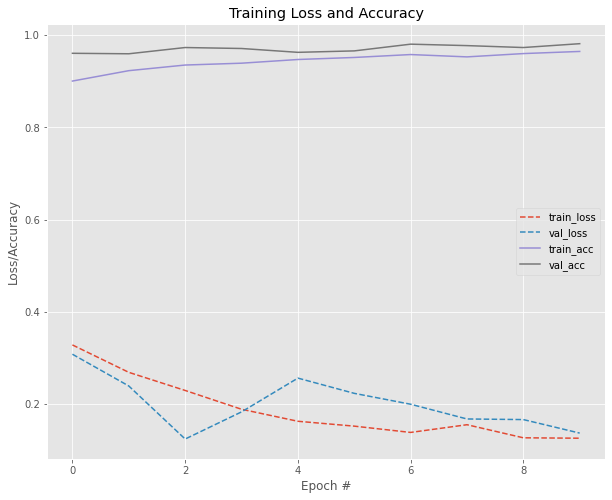

In [72]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 10), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 10), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [73]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "Training Loss and Accuracy transfer learning with fine tuning": wandb.Image(fig),
    }
)

28-11-2022 03:28:37 Uploading figures


In [74]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [75]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
7/7 [==============================] - 1s 156ms/step
              precision    recall  f1-score   support

         cow       0.95      1.00      0.97        70
    elephant       0.98      0.98      0.98        48
       horse       1.00      0.96      0.98       106

    accuracy                           0.98       224
   macro avg       0.98      0.98      0.98       224
weighted avg       0.98      0.98      0.98       224



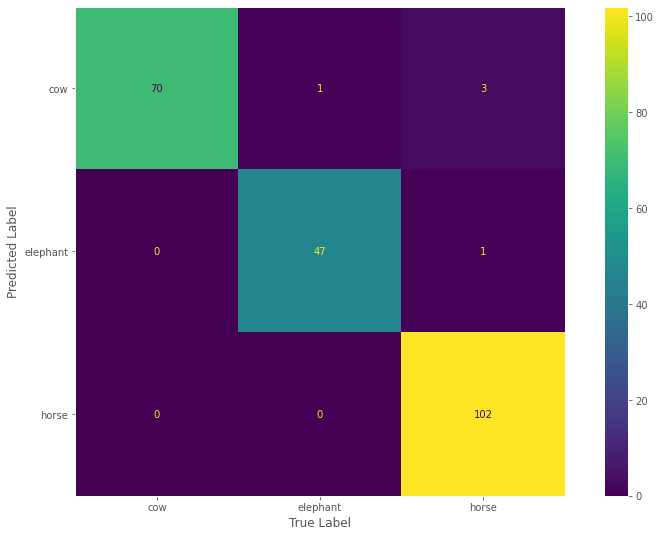

In [79]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(14,9))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [77]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix transfer learning with fine tuning": wandb.Image(fig_confusion_matrix),
    }
)

28-11-2022 03:29:20 Uploading figures


In [78]:
run.finish()